In [1]:
# 包
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
# 超参数设置
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

In [3]:
# 如果没有文件夹就创建一个文件夹
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [37]:
# 图像处理模块：transform设置
# Image processing：归一化（将数据规整到[-1,1],计算公式：channel=（channel-mean）/std）
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],
                                     std=[0.5]
                )]
)

In [38]:
# 加载同时做transform预处理
mnist = torchvision.datasets.MNIST(root='../../../data/minist',
                                   train=True,
                                   transform=transform,
                                   download=True)
# 数据加载器：GAN中只考虑判别模型和生成模型的对抗提高，无需设置训练集和测试集
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)



In [39]:
# 创建判别模型
# Discriminator
D = nn.Sequential(
        nn.Linear(image_size, hidden_size), # 判别的输入时图像数据
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

# 创建生成模型
# Generator 
G = nn.Sequential(
        nn.Linear(latent_size, hidden_size), # 生成的输入是随机数，可以自己定义
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh())

In [40]:
# 设置损失函数和优化器
criterion = nn.BCELoss() # 二值交叉熵 Binary cross entropy loss
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [41]:
# 定义两个函数

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# 重置梯度
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [42]:
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../../data/minist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [43]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    print(epoch)
    for i, (images, _) in enumerate(data_loader):
        
        images = images.reshape(batch_size, -1)
            
        # 创建标签，随后会用于损失函数BCE loss的计算
        real_labels = torch.ones(batch_size, 1)  # true_label设为1，表示True
        fake_labels = torch.zeros(batch_size, 1) # fake_label设为0，表示False

        # ================================================================== #
        #                      训练判别模型                      #
        # ================================================================== #

        # 计算real_损失
        # 使用公式 BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))，来计算realimage的判别损失
        # 其中第二项永远为零，因为real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        
        # 计算fake损失
        # 生成模型根据随机输入生成fake_images
        z = torch.randn(batch_size, latent_size)
        fake_images = G(z) 
        # 使用公式 BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))，来计算fakeImage的判别损失
        # 其中第一项永远为零，因为fake_labels == 0
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 反向传播和优化
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                       训练生成模型                       #
        # ================================================================== #

        # 生成模型根据随机输入生成fake_images,然后判别模型进行判别
        z = torch.randn(batch_size, latent_size)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # 训练生成模型，使之最大化 log(D(G(z)) ，而不是最小化 log(1-D(G(z)))
        # 具体的解释在原文第三小节最后一段有解释
        # 大致含义就是在训练初期，生成模型G还很菜，判别模型会拒绝高置信度的样本，因为这些样本与训练数据不同。
        # 这样log(1-D(G(z)))就近乎饱和，梯度计算得到的值很小，不利于反向传播和训练。
        # 换一种思路，通过计算最大化log(D(G(z))，就能够在训练初期提供较大的梯度值，利于快速收敛
        g_loss = criterion(outputs, real_labels)
        
        # 反向传播和优化
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # 在第一轮保存训练数据图像
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 每一轮保存 生成的样本（即fake_images）
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

0
Epoch [0/200], Step [200/600], d_loss: 0.0464, g_loss: 4.3383, D(x): 0.99, D(G(z)): 0.04
Epoch [0/200], Step [400/600], d_loss: 0.0692, g_loss: 5.7292, D(x): 0.98, D(G(z)): 0.04
Epoch [0/200], Step [600/600], d_loss: 0.0430, g_loss: 4.8351, D(x): 0.99, D(G(z)): 0.03
1
Epoch [1/200], Step [200/600], d_loss: 0.0694, g_loss: 5.1648, D(x): 0.98, D(G(z)): 0.04
Epoch [1/200], Step [400/600], d_loss: 0.1799, g_loss: 3.8660, D(x): 0.94, D(G(z)): 0.05
Epoch [1/200], Step [600/600], d_loss: 0.1576, g_loss: 3.9562, D(x): 0.99, D(G(z)): 0.13
2
Epoch [2/200], Step [200/600], d_loss: 0.0887, g_loss: 6.1795, D(x): 0.96, D(G(z)): 0.03
Epoch [2/200], Step [400/600], d_loss: 0.1164, g_loss: 5.4913, D(x): 0.96, D(G(z)): 0.07
Epoch [2/200], Step [600/600], d_loss: 1.0763, g_loss: 3.3234, D(x): 0.71, D(G(z)): 0.20
3
Epoch [3/200], Step [200/600], d_loss: 0.3132, g_loss: 4.4578, D(x): 0.81, D(G(z)): 0.03
Epoch [3/200], Step [400/600], d_loss: 0.9218, g_loss: 2.7380, D(x): 0.72, D(G(z)): 0.31
Epoch [3/200]

Epoch [30/200], Step [400/600], d_loss: 0.4801, g_loss: 2.4151, D(x): 0.94, D(G(z)): 0.19
Epoch [30/200], Step [600/600], d_loss: 0.3523, g_loss: 2.8145, D(x): 0.91, D(G(z)): 0.08
31
Epoch [31/200], Step [200/600], d_loss: 0.2225, g_loss: 3.5557, D(x): 0.94, D(G(z)): 0.10
Epoch [31/200], Step [400/600], d_loss: 0.3795, g_loss: 4.0062, D(x): 0.92, D(G(z)): 0.15
Epoch [31/200], Step [600/600], d_loss: 0.3349, g_loss: 3.3495, D(x): 0.92, D(G(z)): 0.16
32
Epoch [32/200], Step [200/600], d_loss: 0.4207, g_loss: 3.0028, D(x): 0.85, D(G(z)): 0.07
Epoch [32/200], Step [400/600], d_loss: 0.4044, g_loss: 3.8022, D(x): 0.89, D(G(z)): 0.13
Epoch [32/200], Step [600/600], d_loss: 0.3144, g_loss: 3.9625, D(x): 0.94, D(G(z)): 0.16
33
Epoch [33/200], Step [200/600], d_loss: 0.5007, g_loss: 2.9901, D(x): 0.97, D(G(z)): 0.30
Epoch [33/200], Step [400/600], d_loss: 0.3633, g_loss: 3.5251, D(x): 0.91, D(G(z)): 0.13
Epoch [33/200], Step [600/600], d_loss: 0.3709, g_loss: 2.8944, D(x): 0.86, D(G(z)): 0.09
3

Epoch [60/200], Step [600/600], d_loss: 0.4094, g_loss: 2.8184, D(x): 0.84, D(G(z)): 0.13
61
Epoch [61/200], Step [200/600], d_loss: 0.6034, g_loss: 1.7888, D(x): 0.84, D(G(z)): 0.25
Epoch [61/200], Step [400/600], d_loss: 0.8144, g_loss: 1.6790, D(x): 0.90, D(G(z)): 0.40
Epoch [61/200], Step [600/600], d_loss: 0.6699, g_loss: 2.5744, D(x): 0.78, D(G(z)): 0.18
62
Epoch [62/200], Step [200/600], d_loss: 0.6187, g_loss: 2.0890, D(x): 0.80, D(G(z)): 0.22
Epoch [62/200], Step [400/600], d_loss: 0.4041, g_loss: 2.7356, D(x): 0.85, D(G(z)): 0.13
Epoch [62/200], Step [600/600], d_loss: 0.6275, g_loss: 2.5331, D(x): 0.88, D(G(z)): 0.30
63
Epoch [63/200], Step [200/600], d_loss: 0.7378, g_loss: 2.0894, D(x): 0.73, D(G(z)): 0.15
Epoch [63/200], Step [400/600], d_loss: 0.5141, g_loss: 2.4319, D(x): 0.79, D(G(z)): 0.14
Epoch [63/200], Step [600/600], d_loss: 0.5284, g_loss: 3.6558, D(x): 0.86, D(G(z)): 0.20
64
Epoch [64/200], Step [200/600], d_loss: 0.4568, g_loss: 3.1004, D(x): 0.85, D(G(z)): 0.1

Epoch [91/200], Step [200/600], d_loss: 0.8491, g_loss: 2.2690, D(x): 0.73, D(G(z)): 0.27
Epoch [91/200], Step [400/600], d_loss: 0.8051, g_loss: 1.9026, D(x): 0.79, D(G(z)): 0.32
Epoch [91/200], Step [600/600], d_loss: 0.8104, g_loss: 2.0632, D(x): 0.70, D(G(z)): 0.22
92
Epoch [92/200], Step [200/600], d_loss: 0.7204, g_loss: 1.7888, D(x): 0.79, D(G(z)): 0.29
Epoch [92/200], Step [400/600], d_loss: 0.8677, g_loss: 1.6029, D(x): 0.74, D(G(z)): 0.29
Epoch [92/200], Step [600/600], d_loss: 0.8991, g_loss: 1.4224, D(x): 0.76, D(G(z)): 0.32
93
Epoch [93/200], Step [200/600], d_loss: 1.0053, g_loss: 2.2599, D(x): 0.75, D(G(z)): 0.34
Epoch [93/200], Step [400/600], d_loss: 0.6574, g_loss: 1.8900, D(x): 0.81, D(G(z)): 0.26
Epoch [93/200], Step [600/600], d_loss: 0.8322, g_loss: 1.4039, D(x): 0.75, D(G(z)): 0.31
94
Epoch [94/200], Step [200/600], d_loss: 0.8538, g_loss: 1.1222, D(x): 0.82, D(G(z)): 0.35
Epoch [94/200], Step [400/600], d_loss: 0.7174, g_loss: 1.8050, D(x): 0.78, D(G(z)): 0.28
E

Epoch [121/200], Step [200/600], d_loss: 0.8492, g_loss: 1.5840, D(x): 0.69, D(G(z)): 0.22
Epoch [121/200], Step [400/600], d_loss: 0.6118, g_loss: 1.7155, D(x): 0.81, D(G(z)): 0.25
Epoch [121/200], Step [600/600], d_loss: 0.8943, g_loss: 1.3873, D(x): 0.77, D(G(z)): 0.36
122
Epoch [122/200], Step [200/600], d_loss: 1.0324, g_loss: 2.0264, D(x): 0.68, D(G(z)): 0.30
Epoch [122/200], Step [400/600], d_loss: 0.9565, g_loss: 1.5898, D(x): 0.74, D(G(z)): 0.35
Epoch [122/200], Step [600/600], d_loss: 1.1874, g_loss: 1.3507, D(x): 0.73, D(G(z)): 0.42
123
Epoch [123/200], Step [200/600], d_loss: 0.7487, g_loss: 1.6978, D(x): 0.76, D(G(z)): 0.25
Epoch [123/200], Step [400/600], d_loss: 0.7538, g_loss: 1.5953, D(x): 0.74, D(G(z)): 0.25
Epoch [123/200], Step [600/600], d_loss: 1.2040, g_loss: 1.8097, D(x): 0.69, D(G(z)): 0.40
124
Epoch [124/200], Step [200/600], d_loss: 0.8647, g_loss: 1.7006, D(x): 0.77, D(G(z)): 0.29
Epoch [124/200], Step [400/600], d_loss: 1.0714, g_loss: 1.7948, D(x): 0.62, D

Epoch [150/200], Step [600/600], d_loss: 0.9910, g_loss: 1.2776, D(x): 0.67, D(G(z)): 0.32
151
Epoch [151/200], Step [200/600], d_loss: 1.0699, g_loss: 1.3634, D(x): 0.64, D(G(z)): 0.30
Epoch [151/200], Step [400/600], d_loss: 0.9224, g_loss: 1.4658, D(x): 0.68, D(G(z)): 0.27
Epoch [151/200], Step [600/600], d_loss: 0.7024, g_loss: 1.7997, D(x): 0.78, D(G(z)): 0.27
152
Epoch [152/200], Step [200/600], d_loss: 0.9538, g_loss: 1.6229, D(x): 0.73, D(G(z)): 0.36
Epoch [152/200], Step [400/600], d_loss: 0.9584, g_loss: 1.6065, D(x): 0.68, D(G(z)): 0.32
Epoch [152/200], Step [600/600], d_loss: 0.9646, g_loss: 1.4577, D(x): 0.70, D(G(z)): 0.35
153
Epoch [153/200], Step [200/600], d_loss: 0.9743, g_loss: 1.7639, D(x): 0.69, D(G(z)): 0.30
Epoch [153/200], Step [400/600], d_loss: 0.9170, g_loss: 1.7227, D(x): 0.71, D(G(z)): 0.33
Epoch [153/200], Step [600/600], d_loss: 0.7744, g_loss: 1.8894, D(x): 0.71, D(G(z)): 0.26
154
Epoch [154/200], Step [200/600], d_loss: 0.9741, g_loss: 1.6805, D(x): 0.6

Epoch [180/200], Step [400/600], d_loss: 0.9532, g_loss: 1.4205, D(x): 0.66, D(G(z)): 0.30
Epoch [180/200], Step [600/600], d_loss: 0.7080, g_loss: 1.7459, D(x): 0.74, D(G(z)): 0.23
181
Epoch [181/200], Step [200/600], d_loss: 0.9688, g_loss: 1.3851, D(x): 0.66, D(G(z)): 0.27
Epoch [181/200], Step [400/600], d_loss: 1.0862, g_loss: 1.3960, D(x): 0.60, D(G(z)): 0.28
Epoch [181/200], Step [600/600], d_loss: 0.9566, g_loss: 1.1893, D(x): 0.70, D(G(z)): 0.34
182
Epoch [182/200], Step [200/600], d_loss: 1.0120, g_loss: 1.6882, D(x): 0.64, D(G(z)): 0.29
Epoch [182/200], Step [400/600], d_loss: 0.8125, g_loss: 1.7874, D(x): 0.67, D(G(z)): 0.21
Epoch [182/200], Step [600/600], d_loss: 0.8346, g_loss: 2.0681, D(x): 0.69, D(G(z)): 0.25
183
Epoch [183/200], Step [200/600], d_loss: 0.8580, g_loss: 1.2652, D(x): 0.69, D(G(z)): 0.29
Epoch [183/200], Step [400/600], d_loss: 0.8937, g_loss: 1.7374, D(x): 0.70, D(G(z)): 0.27
Epoch [183/200], Step [600/600], d_loss: 1.1905, g_loss: 1.1058, D(x): 0.62, D

In [45]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

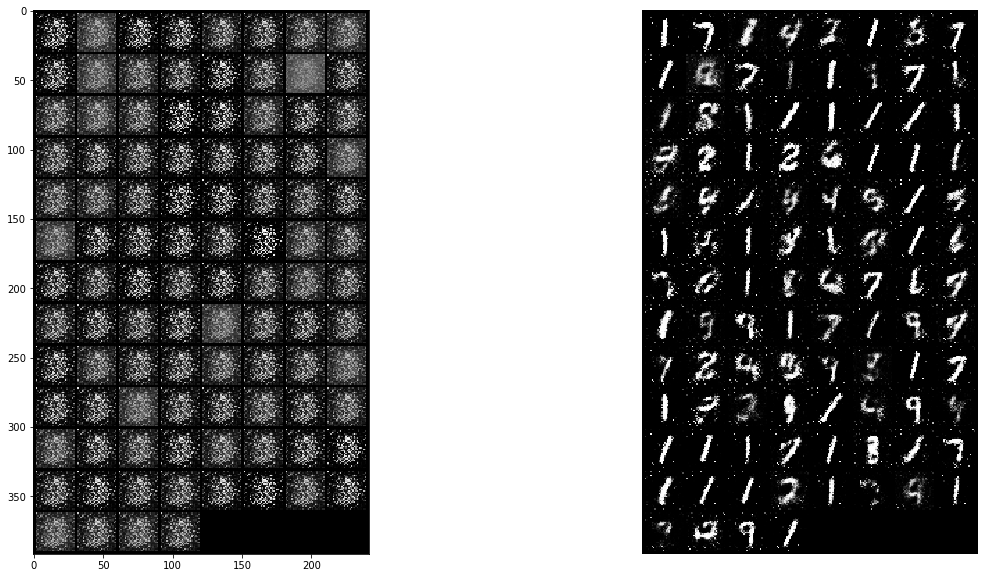

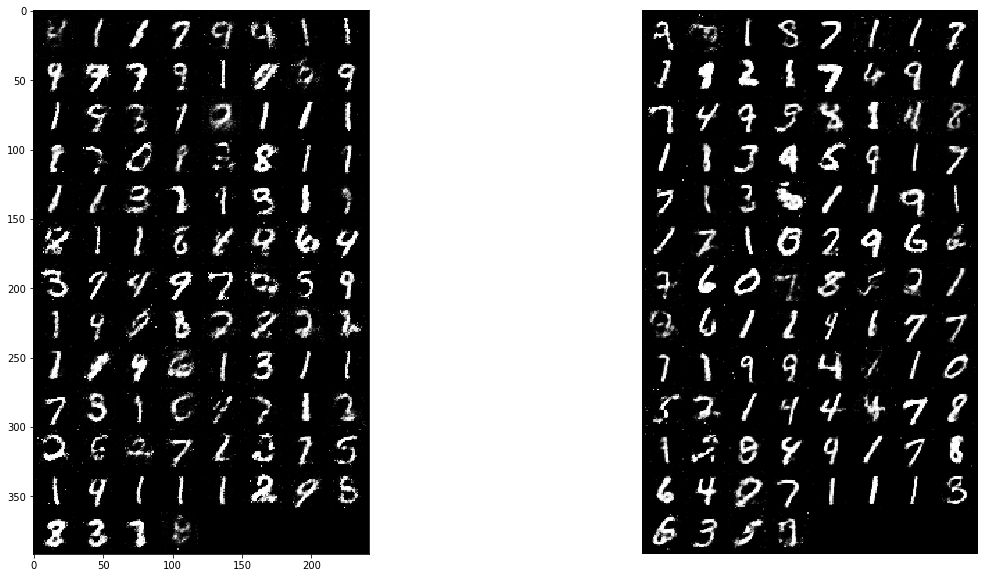

In [49]:
# 起始阶段
fakePath1 = './samples/fake_images-1.png'
fakeImg1 = mpimg.imread(fakePath1)

fakePath5 = './samples/fake_images-50.png'
fakeImg5 = mpimg.imread(fakePath5)



plt.figure(figsize=(20,10))
plt.subplot(1,2,1 ) # 显示图片
plt.imshow(fakeImg1) # 显示图片
plt.subplot(1,2,2 ) # 显示图片
plt.imshow(fakeImg5) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

fakePath195 = './samples/fake_images-100.png'
fakeImg195 = mpimg.imread(fakePath195)

fakePath200 = './samples/fake_images-200.png'
fakeImg200 = mpimg.imread(fakePath200)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1 ) # 显示图片
plt.imshow(fakeImg195) # 显示图片
plt.subplot(1,2,2 ) # 显示图片
plt.imshow(fakeImg200) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()